# Algorithmic trading
### Strategy:
Buy when:
- the close price of the previous day is above the exponential moving average (EMA) of the last 200 days
- the relative strength index (RSI) over the last 10 days is below 30


In [70]:
import pandas as pd
from datetime import datetime
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# choose between: SPY, ^RUI, ^IXIC, QQQ 
dfSPY = yf.download('SPY', start=datetime(2005, 8, 1), end=datetime(2023, 3, 7))# SPY,^SPX, ^GSPC?
#df=yf.download("SPY",start='2020-01-05', end='2021-01-05')

# remove days with no trades
dfSPY = dfSPY[dfSPY.High != dfSPY.Low]
#dfSPY.reset_index(inplace=True)
dfSPY.head(20)
print(len(dfSPY))

[*********************100%***********************]  1 of 1 completed
4429


In [71]:
import pandas_ta as ta
dfSPY['EMA']=ta.ema(dfSPY.Close, length=200)#sma ema
dfSPY['RSI']=ta.rsi(dfSPY.Close, length=10)

dfSPY.dropna(inplace=True)
dfSPY.reset_index(inplace=True)
print(len(dfSPY))
dfSPY.tail(5)

4230


,Date,Open,High,Low,Close,Adj Close,Volume,EMA,RSI
4225,2023-02-28 00:00:00-05:00,397.230011,399.279999,396.149994,396.260010,396.260010,96438600,399.803320,37.665556
4226,2023-03-01 00:00:00-05:00,395.410004,396.690002,393.380005,394.739990,394.739990,99706800,399.752938,35.651902
4227,2023-03-02 00:00:00-05:00,392.679993,398.690002,392.329987,397.809998,397.809998,85127800,399.733605,42.545023
4228,2023-03-03 00:00:00-05:00,399.709991,404.450012,399.029999,404.190002,404.190002,90038300,399.777948,53.938524
4229,2023-03-06 00:00:00-05:00,405.049988,407.450012,404.010010,404.470001,404.470001,72795900,399.824635,54.379668


In [72]:
def buySignal(df):
    signal = [0]*len(df)    
    for row in range(0,len(df)):
        #print(df.iloc[row])
        if (df.Close[row] > df.EMA[row]
            and df.RSI[row] < 30
            and df.RSI[row] > 23):
            #print(df.index[row])
            signal[row] = 2
    return signal

signal = buySignal(dfSPY)
#print(signal)
dfSPY["signal"]=signal
#print(dfSPY.tail())

In [73]:
def addorderslimit(df): # trade entry value
    ordersignal=[0]*len(df)
    for i in range(1, len(df)):
        if df.signal[i]==2:
            ordersignal[i]=df.Open[i+1]
    df['ordersignal']=ordersignal
    
addorderslimit(dfSPY)
#print(dfSPY[dfSPY.signal != 0])

In [74]:
dfSPY[dfSPY.ordersignal!=0].tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,EMA,RSI,signal,ordersignal
3863,2021-09-20 00:00:00-04:00,434.880005,436.559998,428.859985,434.040009,425.615540,166445500,410.347266,26.703670,2,436.529999
3864,2021-09-21 00:00:00-04:00,436.529999,437.910004,433.070007,433.630005,425.213562,92526100,410.578935,26.268904,2,436.049988
3947,2022-01-19 00:00:00-05:00,458.130005,459.609985,451.459991,451.750000,444.538116,109357600,438.841031,28.283899,2,453.750000
3948,2022-01-20 00:00:00-05:00,453.750000,458.739990,444.500000,446.750000,439.617950,122379700,438.919727,24.523799,2,445.559998
3950,2022-01-24 00:00:00-05:00,432.029999,440.380005,420.760010,439.839996,432.818237,251783900,438.919627,23.201453,2,433.059998


# Visualization

Unfortunately, the interactive graphs are not displayed in GitHub.

In [75]:
import numpy as np
def pointposbreak(x):
    if x['signal']!=0:
        #print(x)
        return x['Low']*0.99
    else:
        return np.nan
dfSPY['pointposbreak'] = dfSPY.apply(lambda row: pointposbreak(row), axis=1)

In [76]:
dfpl = dfSPY[100:200].copy()
print(dfpl.index)
print(dfpl.columns)
print(dfpl.head())

RangeIndex(start=100, stop=200, step=1)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EMA',
       'RSI', 'signal', 'ordersignal', 'pointposbreak'],
      dtype='object')
                         Date        Open        High         Low       Close  \
100 2006-10-06 00:00:00-04:00  134.949997  135.100006  134.399994  135.009995   
101 2006-10-09 00:00:00-04:00  134.850006  135.300003  134.639999  135.089996   
102 2006-10-10 00:00:00-04:00  135.100006  135.449997  134.839996  135.270004   
103 2006-10-11 00:00:00-04:00  134.839996  135.429993  134.300003  135.110001   
104 2006-10-12 00:00:00-04:00  135.449997  136.389999  135.399994  136.279999   

     Adj Close     Volume         EMA        RSI  signal  ordersignal  \
100  98.201149   64983600  127.846919  72.391362       0          0.0   
101  98.259361   41176800  127.918989  72.890497       0          0.0   
102  98.390251   56403700  127.992134  74.062816       0          0.0   
103  98.273911  104071800

In [77]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from datetime import datetime

dfpl = dfSPY[-300:-200].copy()
#dfpl=dfpl.drop(columns=['level_0'])#!!!!!!!!!!
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA, line=dict(color='orange', width=2), name="EMA"),
                #go.Scatter(x=dfpl.index, y=dfpl.RSI, line=dict(color='blue', width=2), name="RSI")
                     ])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="Signal")

fig.update_yaxes(range = [dfpl.Low.min()*0.98, dfpl.High.max()*1.02])


fig.show()

In [78]:
dfpl = dfSPY[:].copy()
def SIGNAL(): # returns buy (2) or sell (1) signal
    return dfpl.signal
print(len(dfpl))
print(len(dfpl[dfpl.ordersignal!=0]))
dfpl[dfpl.ordersignal!=0].tail(5)

4230
41


,Date,Open,High,Low,Close,Adj Close,Volume,EMA,RSI,signal,ordersignal,pointposbreak
3863,2021-09-20 00:00:00-04:00,434.880005,436.559998,428.859985,434.040009,425.615540,166445500,410.347266,26.703670,2,436.529999,424.571385
3864,2021-09-21 00:00:00-04:00,436.529999,437.910004,433.070007,433.630005,425.213562,92526100,410.578935,26.268904,2,436.049988,428.739307
3947,2022-01-19 00:00:00-05:00,458.130005,459.609985,451.459991,451.750000,444.538116,109357600,438.841031,28.283899,2,453.750000,446.945392
3948,2022-01-20 00:00:00-05:00,453.750000,458.739990,444.500000,446.750000,439.617950,122379700,438.919727,24.523799,2,445.559998,440.055000
3950,2022-01-24 00:00:00-05:00,432.029999,440.380005,420.760010,439.839996,432.818237,251783900,438.919627,23.201453,2,433.059998,416.552410


In [79]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    initsize = 0.99
    ordertime=[]
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)

    def next(self):
        super().next()
        
        if self.signal==2:# and len(self.trades)==0:
            self.buy(sl=self.data.Low[-1]*0.90, size=self.initsize)   # self.data.Low[-1] # how to access trade entry value
            #print(self.data.Low[-1])
        for j in range(0, len(self.orders)):
            #print(j)
            #print('!!!!!!!!!!!!!!!!!!!', self.data.index[-1])
            #print(self.ordertime)
            #if self.data.index[-1]-self.ordertime[0]>5:#days max to fulfill the order!!!
                #print('----------------------')
                #print(self.orders)
                #print(self.ordertime)
                #self.orders[0].cancel()
                #self.ordertime.pop(0)   
           
            if len(self.trades)>0:
                #print(self.data.index[-1], self.trades)
                if self.data.index[-1]-self.trades[-1].entry_time>=10:#10:
                    self.trades[-1].close()
                    print(self.data.index[-1], self.trades[-1].entry_time)
            
                if self.trades[-1].is_long and self.data.RSI[-1]>=40:
                    #print(self.data.index[-1] - self.trades[-1].entry_time)
                    self.trades[-1].close()
            
bt = Backtest(dfpl, MyStrat, cash=10000, margin=1/5, commission=.00)
stat = bt.run()
stat

1284 1274


Start                                     0.0
End                                    4229.0
Duration                               4229.0
Exposure Time [%]                    3.026005
Equity Final [$]                 39071.395256
Equity Peak [$]                  40894.971092
Return [%]                         290.713953
Buy & Hold Return [%]              212.790974
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.422727
Avg. Drawdown [%]                   -6.809959
Max. Drawdown Duration                  634.0
Avg. Drawdown Duration                  149.6
# Trades                                 31.0
Win Rate [%]                        77.419355
Best Trade [%]                       4.267224
Worst Trade [%]                     -1.089395
Avg. Trade [%]                    

In [80]:
stat['_trades'].tail(5)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
26,487,3369,3371,287.809998,293.470001,2756.421783,0.019666,3369,3371,2
27,471,3640,3644,326.910004,340.859985,6570.441376,0.042672,3640,3644,4
28,9,3865,3867,436.049988,441.440002,48.510132,0.012361,3865,3867,2
29,427,3864,3868,436.529999,442.809998,2681.559479,0.014386,3864,3868,4
30,441,3948,3956,453.750000,450.679993,-1353.873230,-0.006766,3948,3956,8


#### Look at gain vs loss trade duration histogram / average

<AxesSubplot: xlabel='GainOrLoss', ylabel='Duration'>

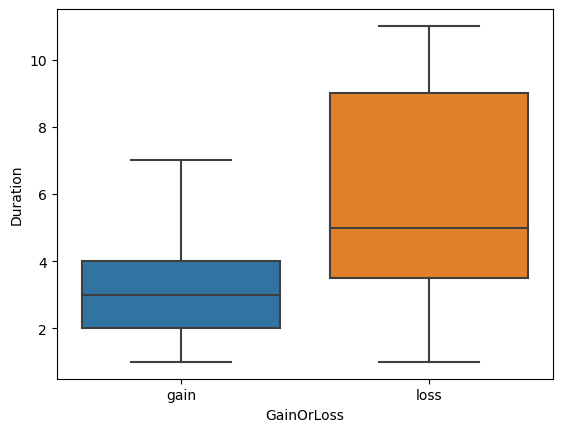

In [81]:
import seaborn as sns

trades = stat['_trades']
trades['GainOrLoss'] = ''
for i in range(len(trades)):
    #print(i)
    if trades.ReturnPct[i] > 0: 
        trades.GainOrLoss[i] = 'gain' 
    else:
        trades.GainOrLoss[i] = 'loss'
sns.boxplot(x = 'GainOrLoss', y = 'Duration', data = trades)

In [82]:
trades.head()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,GainOrLoss
0,1,3,8,126.870003,128.009995,1.139992,0.008986,3,8,5,gain
1,388,2,9,127.349998,127.970001,240.561066,0.004868,2,9,7,gain
2,367,200,204,137.929993,141.309998,1240.461792,0.024505,200,204,4,gain
3,383,301,306,148.210007,147.279999,-356.193039,-0.006275,301,306,5,loss
4,509,934,936,108.150002,109.879997,880.567825,0.015996,934,936,2,gain


In [83]:
bt.plot(show_legend=False)

GridPlot(id='p9482', ...)